# Lab 2: Unit commitment under uncertainty

In this lab we will introduce the unit commitment problem **under uncertainty**, following the sequential decision analytics framework introduced in lecture. We will then introduce three policies for solving this problem: deterministic unit commitment, deterministic unit commitment with operating reserves, and stochastic unit commitment. Finally you will be tasked to compare these three policies, and to attempt to find an optimal policy.

## The problem

In this problem, we are the system operator of the San Diego electric grid, and we have to decide which generators to commit to being on vs off for the next day. **We assume that our decision environment is realistic: we do not actually know the net load for the next day; rather, we only have a forecast.** To simplify the problem, we assume that **all** thermal generators have to be commited in advance; in reality, more flexible generators can often be turned on with just a few hours' notice. We also work with **net load** here instead of overall load, because this is the load that thermal generators have to meet and as a result is the metric that system operators often focus on. See the below example for CAISO:

<img src="img/net_demand.png" style="width: 700px; height: auto" align="left">

Following the framework introduced in lecture, let's examine our metrics, decisions, and sources of uncertainty:
- **Metrics**: we want to minimize costs as measured by start costs, energy costs, and non-served energy (NSE).
- **Decision**: which thermal generators to commit to being on for the next day.
- **Sources of uncertainty**: variations in net load due to weather and consumer decisions.

## How we model the problem

We next identify the components of our problem in order to model and simulate it. The components are:

- **State variable**
    - Static state variable:
        - Generator parameters
        - Historical net load data
        - Non-served energy cost
    - Dynamic state variable:
        - Previous day's net load, which we use to develop a forecast
        - (For a better forecast we might also consider looking at weather forecasts, etc.)
- **Decision variable**
    - $ x_{G,t} $, the commitment schedule for each generator G at each hour t.
- **Exogenous information**
    - $ W_{t+1} = $ actual net load, actual energy cost, actual non-served energy (NSE)
- **Transition function**
    - Update previous day's net load
- **Contribution function**
    - Sum of start costs (known), energy costs, and NSE costs

### In this framework, a unit commitment model is a **policy** for making decisions about the decision variable, which is the commitment schedule, at each time step.

Let's now introduce the three types of policies we will compare:

- **Deterministic unit commitment**, as previously seen in Notebook 5 (variable descriptions are omitted here for brevity):
$$
\begin{align}
\min \ & \sum_{g \in G, t \in T} VarCost_g \times GEN_{g,t} + \sum_{g \in G_{thermal}, t \in T} StartUpCost_g \times START_{g,t} \\
\end{align}
$$
$$
\begin{align}
\text{s.t.} & \\
 & \sum_{g} GEN_{g,t} = Demand_t & \forall \quad t \in T \\
 & GEN_{g,t} \leq Pmax_{g,t} & \forall \quad g \notin G_{thermal} , t \in T \\
 & GEN_{g,t} \geq Pmin_{g,t} & \forall \quad g \notin G_{thermal} , t \in T \\
 & GEN_{g,t} \leq Pmax_{g,t} \times COMMIT_{g,t} & \forall \quad g \in G_{thermal} , t \in T \\
 & GEN_{g,t} \geq Pmin_{g,t} \times COMMIT_{g,t} & \forall \quad g \in G_{thermal} , t \in T \\
 & COMMIT_{g,t} \geq \sum_{t'≥t-MinUp_g}^{t} START_{g,t} & \forall \quad g \in G_{thermal} , t \in T \\
 & 1-COMMIT_{g,t} \geq \sum_{t'≥t-MinDown_g}^{t} SHUT_{g,t} &\forall \quad g \in G_{thermal} , t \in T \\
  & COMMIT_{g,t+1} - COMMIT_{g,t} =&\\
 & \quad START_{g,t+1} - SHUT_{g,t+1} &\forall \quad G_{thermal} \in G , t = 1..T-1 \\
  & GENAUX_{g,t} = GEN_{g,t} - Pmin_{g,t}COMMIT_{g,t} & \forall \quad g \in G_{thermal} , t \in T \\
 & GENAUX_{g,t+1} - GENAUX_{g,t} \leq RampUp_{g} & \forall \quad g \in G_{thermal} , t = 1..T-1 \\
  & GENAUX_{g,t} - GENAUX_{g,t+1} \leq RampDn_{g} & \forall \quad g \in G_{thermal} , t = 1..T-1 \\
 & GEN_{g,t+1} - GEN_{g,t} \leq RampUp_{g} & \forall \quad g \notin G_{thermal} , t = 1..T-1 \\
  & GEN_{g,t} - GEN_{g,t+1} \leq RampDn_{g} & \forall \quad g \notin G_{thermal} , t = 1..T-1  
\end{align}
$$

- **Deterministic unit commitment with operating reserves**, which is the same but with the following additions:
$$
\begin{align}
 & ResReqUp_t = 300 MW + 5\% \times Demand_t  &\forall \quad t \in T \\
 & ResReqDn_t = 5\% \times Demand_t & \forall \quad t \in T
\end{align}
$$

$$
\begin{align}
 & RESUP_{g,t} \leq Pmax_{g,t}COMMIT_{g,t} - GEN_{g,t} & \forall \quad g \in G_{thermal} , t \in T \\
 & RESDN_{g,t} \leq GEN_{g,t} - Pmin_{g,t}COMMIT_{g,t} & \forall \quad g \in G_{thermal} , t \in T \\
 & RESUP_{g,t} \leq RampUp_{g} & \forall \quad g \in G_{thermal}, t \in T\\ 
 & RESDN_{g,t} \leq RampDn_{g} & \forall \quad g \in G_{thermal}, t \in T \\
 & \sum_{g \in G_{thermal}} RESUP_{g,t} \geq ResReqUp_t & \forall \quad t \in T \\
 & \sum_{g \in G_{thermal}} RESDN_{g,t} \geq ResReqDn_t & \forall \quad t \in T
\end{align}
$$

- **Stochastic unit commitment**, which simply adds scenarios and averages over them (note the commitment variables are not scenario-specific; we have to decide on only one schedule).
$$
\begin{align}
\min \ & \sum_{g \in G, t \in T, n \in N} VarCost_g \times GEN_{g,t,n} * \frac{1}{N} + \sum_{g \in G_{thermal}, t \in T} StartUpCost_g \times START_{g,t} \\
\end{align}
$$
$$
\begin{align}
\text{s.t.} & \\
 & \sum_{g} GEN_{g,t,n} = Demand_t & \forall \quad t \in T \\
 & GEN_{g,t,n} \leq Pmax_{g,t} & \forall \quad g \notin G_{thermal} , t \in T, n \in N \\
 & GEN_{g,t,n} \geq Pmin_{g,t} & \forall \quad g \notin G_{thermal} , t \in T, n \in N  \\
 & GEN_{g,t,n} \leq Pmax_{g,t} \times COMMIT_{g,t} & \forall \quad g \in G_{thermal} , t \in T, n \in N  \\
 & GEN_{g,t,n} \geq Pmin_{g,t} \times COMMIT_{g,t} & \forall \quad g \in G_{thermal} , t \in T, n \in N  \\
 & COMMIT_{g,t} \geq \sum_{t'≥t-MinUp_g}^{t} START_{g,t} & \forall \quad g \in G_{thermal} , t \in T \\
 & 1-COMMIT_{g,t} \geq \sum_{t'≥t-MinDown_g}^{t} SHUT_{g,t} &\forall \quad g \in G_{thermal} , t \in T \\
  & COMMIT_{g,t+1} - COMMIT_{g,t} =&\\
 & \quad START_{g,t+1} - SHUT_{g,t+1} &\forall \quad G_{thermal} \in G , t = 1..T-1 \\
  & GENAUX_{g,t,n} = GEN_{g,t,n} - Pmin_{g,t}COMMIT_{g,t} & \forall \quad g \in G_{thermal} , t \in T, n \in N  \\
 & GENAUX_{g,t+1,n} - GENAUX_{g,t,n} \leq RampUp_{g} & \forall \quad g \in G_{thermal} , t = 1..T-1, n \in N  \\
  & GENAUX_{g,t,n} - GENAUX_{g,t+1,n} \leq RampDn_{g} & \forall \quad g \in G_{thermal} , t = 1..T-1, n \in N  \\
 & GEN_{g,t+1,n} - GEN_{g,t,n} \leq RampUp_{g} & \forall \quad g \notin G_{thermal} , t = 1..T-1, n \in N  \\
  & GEN_{g,t,n} - GEN_{g,t+1,n} \leq RampDn_{g} & \forall \quad g \notin G_{thermal} , t = 1..T-1, n \in N   
\end{align}
$$

Now let's add the code. First we will load in the data, then add the code for each model.

In [3]:
using JuMP, Gurobi
using Plots;
using VegaLite  # to make some nice plots
using DataFrames, CSV, PrettyTables
ENV["COLUMNS"]=120; # Set so all columns of DataFrames and Matrices are displayed

datadir = joinpath("Lab2_data") 
gen_info = CSV.read(joinpath(datadir,"Generators_data.csv"), DataFrame);
fuels = CSV.read(joinpath(datadir,"Fuels_data.csv"), DataFrame);
loads = CSV.read(joinpath(datadir,"Demand.csv"), DataFrame);
gen_variable = CSV.read(joinpath(datadir,"Generators_variability.csv"), DataFrame);

# Rename all columns to lowercase (by convention)
for f in [gen_info, fuels, loads, gen_variable]
    rename!(f,lowercase.(names(f)))
end

# Keep columns relevant to our UC model 
select!(gen_info, 1:26) # columns 1:26
gen_df = outerjoin(gen_info,  fuels, on = :fuel) # load in fuel costs and add to data frame
rename!(gen_df, :cost_per_mmbtu => :fuel_cost)   # rename column for fuel cost
gen_df.fuel_cost[ismissing.(gen_df[:,:fuel_cost])] .= 0

# # create "is_variable" column to indicate if this is a variable generation source (e.g. wind, solar):
gen_df[!, :is_variable] .= false
gen_df[in(["onshore_wind_turbine","small_hydroelectric","solar_photovoltaic"]).(gen_df.resource),:is_variable] .= true;

# create full name of generator (including geographic location and cluster number)
#  for use with variable generation dataframe
gen_df.gen_full = lowercase.(gen_df.region .* "_" .* gen_df.resource .* "_" .* string.(gen_df.cluster) .* ".0");

# remove generators with no capacity (e.g. new build options that we'd use if this was capacity expansion problem)
gen_df = gen_df[gen_df.existing_cap_mw .> 0,:];

# increase solar
gen_df[gen_df.resource .== "solar_photovoltaic",:existing_cap_mw] .= 2500

# convert from GMT to GMT-8
gen_variable.hour = mod.(gen_variable.hour .- 9, 8760) .+ 1 
sort!(gen_variable, :hour)
loads.hour = mod.(loads.hour .- 9, 8760) .+ 1
sort!(loads, :hour);

# get net load

gen_variable_copy = copy(gen_variable)
gen_variable_vre = gen_variable_copy[:,end-2:end]
vre_gen = vec(sum(Matrix(gen_variable_vre) .* gen_df[end-2:end,:existing_cap_mw]', dims=2))
net_load = copy(loads)
net_load[!,:demand] = net_load[!,:demand] - vre_gen

# remove renewables from generator inputs
gen_df_no_vre=copy(gen_df[1:end-3,:])
gen_variable_no_vre=copy(gen_variable[:,1:end-3])

# # 2. Convert from "wide" to "long" format
gen_variable_long = stack(gen_variable_no_vre, 
                        Not(:hour), 
                        variable_name=:gen_full,
                        value_name=:cf);

function value_to_df_2dim(var)
    solution = DataFrame(var.data, :auto)
    ax1 = var.axes[1]
    ax2 = var.axes[2]
    cols = names(solution)
    insertcols!(solution, 1, :r_id => ax1)
    solution = stack(solution, Not(:r_id), variable_name=:hour)
    solution.hour = foldl(replace, [cols[i] => ax2[i] for i in 1:length(ax2)], init=solution.hour)
    rename!(solution, :value => :gen)
    solution.hour = convert.(Int64,solution.hour)
    return solution
end

value_to_df_2dim (generic function with 1 method)

In [4]:
function unit_commitment_deterministic(gen_df, loads, mip_gap, nse_cost)
    UC = Model(Gurobi.Optimizer)
    set_optimizer_attribute(UC, "MIPGap", mip_gap) 
    set_optimizer_attribute(UC, "OutputFlag", 0)

    # Define sets based on data
    # Note the creation of several different sets of generators for use in
    # different equations.
    G_thermal = gen_df[gen_df[!,:up_time] .> 0,:r_id]
    G_nonthermal = gen_df[gen_df[!,:up_time] .== 0,:r_id]
    G_nonvar = gen_df[gen_df[!,:is_variable] .== 0,:r_id]
    G_nt_nonvar = intersect(G_nonvar, G_nonthermal)
    G = gen_df.r_id
    T = loads.hour
    T_red = loads.hour[1:end-1]  # reduced time periods without last one
        
    # Decision variables   
    @variables(UC, begin
        GEN[G, T]  >= 0     # generation
        GENAUX[G_thermal, T] >= 0 # auxiliary generation variable
        COMMIT[G_thermal, T], Bin # commitment status (Bin=binary)
        START[G_thermal, T], Bin  # startup decision
        SHUT[G_thermal, T], Bin   # shutdown decision
        NSE[T]>=0 #non-served energy
    end)

    @expression(UC, eStartCost, sum(
            gen_df[gen_df.r_id .== i,:start_cost_per_mw][1] * 
            gen_df[gen_df.r_id .== i,:existing_cap_mw][1] *
            START[i,t] 
            for i in G_thermal for t in T))
                
    # Objective function
    @objective(UC, Min, sum(
            (
                gen_df[gen_df.r_id .== i,:heat_rate_mmbtu_per_mwh][1] * gen_df[gen_df.r_id .== i,:fuel_cost][1]
                + gen_df[gen_df.r_id .== i,:var_om_cost_per_mwh][1]
            )
            * GEN[i,t] 
            for i in G_nonvar for t in T
        )
        + eStartCost
        + sum(NSE[t]*nse_cost for t in T)
    )
    
    # Demand constraint
    @constraint(UC, cDemand[t in T], 
        sum(GEN[i,t] for i in G) + NSE[t] == loads[loads.hour .== t,:demand][1])

    # Capacity constraints (thermal generators requiring commitment)
    @constraint(UC, Cap_thermal_min[i in G_thermal, t in T], 
        GEN[i,t] >= COMMIT[i, t] * gen_df[gen_df.r_id .== i,:existing_cap_mw][1] *
                        gen_df[gen_df.r_id .== i,:min_power][1])
    @constraint(UC, Cap_thermal_max[i in G_thermal, t in T], 
        GEN[i,t] <= COMMIT[i, t] * gen_df[gen_df.r_id .== i,:existing_cap_mw][1])

    # Capacity constraints (non-variable generation not requiring commitment)
    @constraint(UC, Cap_nt_nonvar[i in G_nt_nonvar, t in T], 
        GEN[i,t] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1])
    
    # Unit commitment constraints
    @constraint(UC, Startup[i in G_thermal, t in T],
        COMMIT[i, t] >= sum(START[i, tt] 
                        for tt in intersect(T,
                            (t-gen_df[gen_df.r_id .== i,:up_time][1]):t)))

    @constraint(UC, Shutdown[i in G_thermal, t in T],
        1-COMMIT[i, t] >= sum(SHUT[i, tt] 
                        for tt in intersect(T,
                            (t-gen_df[gen_df.r_id .== i,:down_time][1]):t)))
    
    @constraint(UC, CommitmentStatus[i in G_thermal, t in T_red],
        COMMIT[i,t+1] - COMMIT[i,t] == START[i,t+1] - SHUT[i,t+1])
    
    # New auxiliary variable GENAUX for generation above the minimum output level
    # for committed thermal units (only created for thermal generators)
    @constraint(UC, AuxGen[i in G_thermal, t in T],
        GENAUX[i,t] == GEN[i,t] - COMMIT[i, t] * gen_df[gen_df.r_id .== i,:existing_cap_mw][1] *
                        gen_df[gen_df.r_id .== i,:min_power][1])
    
    # Ramp equations for thermal generators (constraining GENAUX)
    @constraint(UC, RampUp_thermal[i in G_thermal, t in T_red], 
        GENAUX[i,t+1] - GENAUX[i,t] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1] * 
                                 gen_df[gen_df.r_id .== i,:ramp_up_percentage][1] )

    @constraint(UC, RampDn_thermal[i in G_thermal, t in T_red], 
        GENAUX[i,t] - GENAUX[i,t+1] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1] * 
                                 gen_df[gen_df.r_id .== i,:ramp_dn_percentage][1] )

    # Ramp equations for non-thermal generators (constraining total generation GEN)
    @constraint(UC, RampUp_nonthermal[i in G_nonthermal, t in T_red], 
        GEN[i,t+1] - GEN[i,t] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1] * 
                                 gen_df[gen_df.r_id .== i,:ramp_up_percentage][1] )

    @constraint(UC, RampDn[i in G, t in T_red], 
        GEN[i,t] - GEN[i,t+1] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1] * 
                                 gen_df[gen_df.r_id .== i,:ramp_dn_percentage][1] )
      
    
    # Solve statement (! indicates runs in place)
    optimize!(UC)

    # Generation solution
    gen = value_to_df_2dim(value.(GEN))

    # Commitment status solution
    commit = value_to_df_2dim(value.(COMMIT))
    rename!(commit, "gen" => "commit")

    nse=value.(NSE).data
    
    # Return the solution and objective as named tuple
    return (
        gen,
        commit,
        nse,
        cost = objective_value(UC),
        status = termination_status(UC),
        start_cost = value.(eStartCost),
    )

end

unit_commitment_deterministic (generic function with 1 method)

In [5]:
function unit_commitment_reserves(gen_df, loads, mip_gap, nse_cost, reserve_requirement_pct)
    UC = Model(Gurobi.Optimizer)
    set_optimizer_attribute(UC, "MIPGap", mip_gap)
    set_optimizer_attribute(UC, "OutputFlag", 0)

    # Define sets based on data
    # Note the creation of several different sets of generators for use in
    # different equations.
    G_thermal = gen_df[gen_df[!,:up_time] .> 0,:r_id]
    G_nonthermal = gen_df[gen_df[!,:up_time] .== 0,:r_id]
    G_nonvar = gen_df[gen_df[!,:is_variable] .== 0,:r_id]
    G_nt_nonvar = intersect(G_nonvar, G_nonthermal)
    G = gen_df.r_id
    T = loads.hour
    T_red = loads.hour[1:end-1]  # reduced time periods without last one
    
    # Compute reserve requirements
    ResReqUp = Dict(T[i] => 300  
              + reserve_requirement_pct * loads[loads.hour .== T[i],:demand][1]
                    for i in 1:length(T))
    ResReqDn = Dict(T[i] => 0
              + reserve_requirement_pct * loads[loads.hour .== T[i],:demand][1]                    
                    for i in 1:length(T))
    
    # Decision variables   
    @variables(UC, begin
        GEN[G, T]  >= 0     # generation
        GENAUX[G_thermal, T] >= 0 # auxiliary generation variable
        COMMIT[G_thermal, T], Bin # commitment status (Bin=binary)
        START[G_thermal, T], Bin  # startup decision
        SHUT[G_thermal, T], Bin   # shutdown decision
        RESUP[G_thermal, T]       # up reserve capacity
        RESDN[G_thermal, T]       # down reserve capacity
        NSE[T]>=0 #non-served energy
    end)

    @expression(UC, eStartCost, sum(
            gen_df[gen_df.r_id .== i,:start_cost_per_mw][1] * 
            gen_df[gen_df.r_id .== i,:existing_cap_mw][1] *
            START[i,t] 
            for i in G_thermal for t in T))
                
    # Objective function
    @objective(UC, Min, 
        sum(
            (
                gen_df[gen_df.r_id .== i,:heat_rate_mmbtu_per_mwh][1] * gen_df[gen_df.r_id .== i,:fuel_cost][1]
                + gen_df[gen_df.r_id .== i,:var_om_cost_per_mwh][1]
            ) * GEN[i,t] 
            for i in G_nonvar for t in T
        )
        + eStartCost
        + sum(NSE[t]*nse_cost for t in T)
    )
    
    # Demand constraint
    @constraint(UC, cDemand[t in T], 
        sum(GEN[i,t] for i in G) + NSE[t] == loads[loads.hour .== t,:demand][1])

    # Capacity constraints (thermal generators requiring commitment)
    @constraint(UC, Cap_thermal_min[i in G_thermal, t in T], 
        GEN[i,t] >= COMMIT[i, t] * gen_df[gen_df.r_id .== i,:existing_cap_mw][1] *
                        gen_df[gen_df.r_id .== i,:min_power][1])
    @constraint(UC, Cap_thermal_max[i in G_thermal, t in T], 
        GEN[i,t] <= COMMIT[i, t] * gen_df[gen_df.r_id .== i,:existing_cap_mw][1])

    # Capacity constraints (non-variable generation not requiring commitment)
    @constraint(UC, Cap_nt_nonvar[i in G_nt_nonvar, t in T], 
        GEN[i,t] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1])
    
    # Unit commitment constraints
    @constraint(UC, Startup[i in G_thermal, t in T],
        COMMIT[i, t] >= sum(START[i, tt] 
                        for tt in intersect(T,
                            (t-gen_df[gen_df.r_id .== i,:up_time][1]):t)))

    @constraint(UC, Shutdown[i in G_thermal, t in T],
        1-COMMIT[i, t] >= sum(SHUT[i, tt] 
                        for tt in intersect(T,
                            (t-gen_df[gen_df.r_id .== i,:down_time][1]):t)))
    
    @constraint(UC, CommitmentStatus[i in G_thermal, t in T_red],
        COMMIT[i,t+1] - COMMIT[i,t] == START[i,t+1] - SHUT[i,t+1])
    
    # Auxiliary variable
    @constraint(UC, AuxGen[i in G_thermal, t in T],
        GENAUX[i,t] == GEN[i,t] - COMMIT[i, t] * gen_df[gen_df.r_id .== i,:existing_cap_mw][1] *
                        gen_df[gen_df.r_id .== i,:min_power][1])
    
    # Ramp equations (thermal generators)
    @constraint(UC, RampUp_thermal[i in G_thermal, t in T_red], 
        GENAUX[i,t+1] - GENAUX[i,t] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1] * 
                                 gen_df[gen_df.r_id .== i,:ramp_up_percentage][1] )

    @constraint(UC, RampDn_thermal[i in G_thermal, t in T_red], 
        GENAUX[i,t] - GENAUX[i,t+1] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1] * 
                                 gen_df[gen_df.r_id .== i,:ramp_dn_percentage][1] )

    # Ramp equations (non-thermal generators)
    @constraint(UC, RampUp_nonthermal[i in G_nonthermal, t in T_red], 
        GEN[i,t+1] - GEN[i,t] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1] * 
                                 gen_df[gen_df.r_id .== i,:ramp_up_percentage][1] )

    @constraint(UC, RampDn[i in G, t in T_red], 
        GEN[i,t] - GEN[i,t+1] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1] * 
                                 gen_df[gen_df.r_id .== i,:ramp_dn_percentage][1] )
      
    # Reserve equations
    # (1) Reserves limited by committed capacity of generator
    @constraint(UC, ResUpCap[i in G_thermal, t in T],
        RESUP[i,t] <= COMMIT[i, t] * gen_df[gen_df.r_id .== i,:existing_cap_mw][1]
                        - GEN[i,t])

    @constraint(UC, ResDnCap[i in G_thermal, t in T],
        RESDN[i,t] <= GEN[i,t] - 
                        COMMIT[i, t] * gen_df[gen_df.r_id .== i,:existing_cap_mw][1] *
                        gen_df[gen_df.r_id .== i,:min_power][1])

    # (2) Reserves limited by ramp rates
    @constraint(UC, ResUpRamp[i in G_thermal, t in T],
        RESUP[i,t] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1] * 
                          gen_df[gen_df.r_id .== i,:ramp_up_percentage][1])

    @constraint(UC, ResDnRamp[i in G_thermal, t in T],
        RESDN[i,t] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1] * 
                          gen_df[gen_df.r_id .== i,:ramp_dn_percentage][1])

    # (3) Overall reserve requirements
    @constraint(UC, ResUpRequirement[t in T],
        sum(RESUP[i,t] for i in G_thermal) >= 
                ResReqUp[t])

    @constraint(UC, ResDnRequirement[t in T],
        sum(RESDN[i,t] for i in G_thermal) >= 
                ResReqDn[t])

    # Solve statement (! indicates runs in place)
    optimize!(UC)

    # Generation solution
    gen = value_to_df_2dim(value.(GEN))

    # Commitment status solution
    commit = value_to_df_2dim(value.(COMMIT))
    rename!(commit, "gen" => "commit")

    nse=value.(NSE).data
    
    # Return the solution and objective as named tuple
    return (
        gen,
        commit,
        nse,
        cost = objective_value(UC),
        status = termination_status(UC),
        start_cost = value.(eStartCost)
    )

end

unit_commitment_reserves (generic function with 1 method)

In [6]:
function unit_commitment_stochastic(gen_df, loads::Matrix, mip_gap, nse_cost)
    # loads is now a 24xn matrix where n is the number of scenarios
    UC = Model(Gurobi.Optimizer)
    set_optimizer_attribute(UC, "MIPGap", mip_gap) 
    set_optimizer_attribute(UC, "OutputFlag", 0)

    # Define sets based on data
    # Note the creation of several different sets of generators for use in
    # different equations.
    G_thermal = gen_df[gen_df[!,:up_time] .> 0,:r_id]
    G_nonthermal = gen_df[gen_df[!,:up_time] .== 0,:r_id]
    G_nonvar = gen_df[gen_df[!,:is_variable] .== 0,:r_id]
    G_nt_nonvar = intersect(G_nonvar, G_nonthermal)
    G = gen_df.r_id
    T = Vector(1:24)
    T_red = T[1:end-1]  # reduced time periods without last one
    num_scenarios = size(loads)[2]
    N = 1:num_scenarios
        
    # Decision variables   
    @variables(UC, begin
        GEN[G, T, N]  >= 0     # generation
        GENAUX[G_thermal, T, N] >= 0 # auxiliary generation variable
        COMMIT[G_thermal, T], Bin # commitment status (Bin=binary)- not scenario specific
        START[G_thermal, T], Bin  # startup decision- not scenario specific
        SHUT[G_thermal, T], Bin   # shutdown decision- not scenario specific
        NSE[T, N]>=0 #non-served energy
    end)

    @expression(UC, eStartCost, sum(
            gen_df[gen_df.r_id .== i,:start_cost_per_mw][1] * 
            gen_df[gen_df.r_id .== i,:existing_cap_mw][1] *
            START[i,t] 
            for i in G_thermal for t in T))

    # Objective function
    @objective(UC, Min, sum(
            (
                gen_df[gen_df.r_id .== i,:heat_rate_mmbtu_per_mwh][1] * gen_df[gen_df.r_id .== i,:fuel_cost][1]
                + gen_df[gen_df.r_id .== i,:var_om_cost_per_mwh][1]
            )
            * GEN[i,t,n] 
            for i in G_nonvar for t in T for n in N
        ) / num_scenarios
        + eStartCost
        + sum(NSE[t,n]*nse_cost for t in T for n in N) / num_scenarios
    )
    
    # Demand constraint
    @constraint(UC, cDemand[t in T, n in N],
        sum(GEN[i,t,n] for i in G) + NSE[t,n] == loads[t,n])

    # Capacity constraints (thermal generators requiring commitment)
    @constraint(UC, Cap_thermal_min[i in G_thermal, t in T, n in N], 
        GEN[i,t,n] >= COMMIT[i, t] * gen_df[gen_df.r_id .== i,:existing_cap_mw][1] *
                        gen_df[gen_df.r_id .== i,:min_power][1])
    @constraint(UC, Cap_thermal_max[i in G_thermal, t in T, n in N], 
        GEN[i,t,n] <= COMMIT[i, t] * gen_df[gen_df.r_id .== i,:existing_cap_mw][1])

    # Capacity constraints (non-variable generation not requiring commitment)
    @constraint(UC, Cap_nt_nonvar[i in G_nt_nonvar, t in T, n in N], 
        GEN[i,t,n] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1])
    
    # Unit commitment constraints
    @constraint(UC, Startup[i in G_thermal, t in T],
        COMMIT[i, t] >= sum(START[i, tt] 
                        for tt in intersect(T,
                            (t-gen_df[gen_df.r_id .== i,:up_time][1]):t)))

    @constraint(UC, Shutdown[i in G_thermal, t in T],
        1-COMMIT[i, t] >= sum(SHUT[i, tt] 
                        for tt in intersect(T,
                            (t-gen_df[gen_df.r_id .== i,:down_time][1]):t)))
    
    @constraint(UC, CommitmentStatus[i in G_thermal, t in T_red],
        COMMIT[i,t+1] - COMMIT[i,t] == START[i,t+1] - SHUT[i,t+1])
    
    # New auxiliary variable GENAUX for generation above the minimum output level
    # for committed thermal units (only created for thermal generators)
    @constraint(UC, AuxGen[i in G_thermal, t in T, n in N],
        GENAUX[i,t,n] == GEN[i,t,n] - COMMIT[i, t] * gen_df[gen_df.r_id .== i,:existing_cap_mw][1] *
                        gen_df[gen_df.r_id .== i,:min_power][1])
    
    # Ramp equations for thermal generators (constraining GENAUX)
    @constraint(UC, RampUp_thermal[i in G_thermal, t in T_red, n in N], 
        GENAUX[i,t+1,n] - GENAUX[i,t,n] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1] * 
                                 gen_df[gen_df.r_id .== i,:ramp_up_percentage][1] )

    @constraint(UC, RampDn_thermal[i in G_thermal, t in T_red, n in N], 
        GENAUX[i,t,n] - GENAUX[i,t+1,n] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1] * 
                                 gen_df[gen_df.r_id .== i,:ramp_dn_percentage][1] )

    # Ramp equations for non-thermal generators (constraining total generation GEN)
    @constraint(UC, RampUp_nonthermal[i in G_nonthermal, t in T_red, n in N], 
        GEN[i,t+1,n] - GEN[i,t,n] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1] * 
                                 gen_df[gen_df.r_id .== i,:ramp_up_percentage][1] )

    @constraint(UC, RampDn[i in G, t in T_red, n in N], 
        GEN[i,t,n] - GEN[i,t+1,n] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1] * 
                                 gen_df[gen_df.r_id .== i,:ramp_dn_percentage][1] )
      
    
    # Solve statement (! indicates runs in place)
    optimize!(UC)

    # Generation solution
    gen_all_scenarios=Dict()
    for n in N
        gen_all_scenarios[n] = value_to_df_2dim(value.(GEN[:,:,n]))
    end

    # Commitment status solution
    commit = value_to_df_2dim(value.(COMMIT))
    rename!(commit, "gen" => "commit")

    nse=value.(NSE).data
    
    # Return the solution and objective as named tuple
    return (
        gen_all_scenarios,
        commit,
        nse,
        cost = objective_value(UC),
        status = termination_status(UC),
        start_cost = value.(eStartCost)
    )

end

unit_commitment_stochastic (generic function with 1 method)

In [7]:
# We also need an economic dispatch function:

function economic_dispatch(gen_df, loads, mip_gap, commit, nse_cost)
    UC = Model(Gurobi.Optimizer)
    set_optimizer_attribute(UC, "MIPGap", mip_gap)
    set_optimizer_attribute(UC, "OutputFlag", 0)

    # Define sets based on data
    # Note the creation of several different sets of generators for use in
    # different equations.
    G_thermal = gen_df[gen_df[!,:up_time] .> 0,:r_id]
    G_nonthermal = gen_df[gen_df[!,:up_time] .== 0,:r_id]
    G_nonvar = gen_df[gen_df[!,:is_variable] .== 0,:r_id]
    G_nt_nonvar = intersect(G_nonvar, G_nonthermal)
    G = gen_df.r_id
    T = loads.hour
    T_red = loads.hour[1:end-1]  # reduced time periods without last one
        
    # Decision variables   
    @variables(UC, begin
        GEN[G, T]  >= 0     # generation
        GENAUX[G_thermal, T] >= 0 # auxiliary generation variable
        COMMIT[G_thermal, T] # commitment status (will be fixed to input commit state)
        1>=START[G_thermal, T]>=0  # startup decision
        1>=SHUT[G_thermal, T]>=0   # shutdown decision
        NSE[T]>=0 #non-served energy
    end)
                
    # Objective function (broken out with expressions so we can output)
    
    @expression(UC, eEnergyCost, sum((
                gen_df[gen_df.r_id .== i,:heat_rate_mmbtu_per_mwh][1] * gen_df[gen_df.r_id .== i,:fuel_cost][1]
                + gen_df[gen_df.r_id .== i,:var_om_cost_per_mwh][1]
            ) * GEN[i,t] 
            for i in G_nonvar for t in T))

    @expression(UC, eStartCost, sum(
            gen_df[gen_df.r_id .== i,:start_cost_per_mw][1] * 
            gen_df[gen_df.r_id .== i,:existing_cap_mw][1] *
            START[i,t] 
            for i in G_thermal for t in T))

    @expression(UC, eNSECost, sum(NSE[t]*nse_cost for t in T))
    
    @objective(UC, Min, eEnergyCost + eStartCost + eNSECost)

    # Constrain commit status to inputs
    @constraint(UC, cCommit[i in G_thermal, t in T],
        COMMIT[i,t] == commit[(commit.r_id.==i) .& (commit.hour.==t),"commit"][1])
    
    # Demand constraint
    @constraint(UC, cDemand[t in T], 
        sum(GEN[i,t] for i in G) + NSE[t] == loads[loads.hour .== t,:demand][1])

    # Capacity constraints (thermal generators requiring commitment)
    @constraint(UC, Cap_thermal_min[i in G_thermal, t in T], 
        GEN[i,t] >= COMMIT[i, t] * gen_df[gen_df.r_id .== i,:existing_cap_mw][1] *
                        gen_df[gen_df.r_id .== i,:min_power][1])
    @constraint(UC, Cap_thermal_max[i in G_thermal, t in T], 
        GEN[i,t] <= COMMIT[i, t] * gen_df[gen_df.r_id .== i,:existing_cap_mw][1])

    # Capacity constraints (non-variable generation not requiring commitment)
    @constraint(UC, Cap_nt_nonvar[i in G_nt_nonvar, t in T], 
        GEN[i,t] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1])

    # still need to define start and shut so we can get start costs
    @constraint(UC, CommitmentStatus[i in G_thermal, t in T_red],
        COMMIT[i,t+1] - COMMIT[i,t] == START[i,t+1] - SHUT[i,t+1])
    
    # New auxiliary variable GENAUX for generation above the minimum output level
    # for committed thermal units (only created for thermal generators)
    @constraint(UC, AuxGen[i in G_thermal, t in T],
        GENAUX[i,t] == GEN[i,t] - COMMIT[i, t] * gen_df[gen_df.r_id .== i,:existing_cap_mw][1] *
                        gen_df[gen_df.r_id .== i,:min_power][1])
    
    # Ramp equations for thermal generators (constraining GENAUX)
    @constraint(UC, RampUp_thermal[i in G_thermal, t in T_red], 
        GENAUX[i,t+1] - GENAUX[i,t] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1] * 
                                 gen_df[gen_df.r_id .== i,:ramp_up_percentage][1] )

    @constraint(UC, RampDn_thermal[i in G_thermal, t in T_red], 
        GENAUX[i,t] - GENAUX[i,t+1] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1] * 
                                 gen_df[gen_df.r_id .== i,:ramp_dn_percentage][1] )

    # Ramp equations for non-thermal generators (constraining total generation GEN)
    @constraint(UC, RampUp_nonthermal[i in G_nonthermal, t in T_red], 
        GEN[i,t+1] - GEN[i,t] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1] * 
                                 gen_df[gen_df.r_id .== i,:ramp_up_percentage][1] )

    @constraint(UC, RampDn[i in G, t in T_red], 
        GEN[i,t] - GEN[i,t+1] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1] * 
                                 gen_df[gen_df.r_id .== i,:ramp_dn_percentage][1] )
      
    
    # Solve statement (! indicates runs in place)
    optimize!(UC)

    # Generation solution
    gen = value_to_df_2dim(value.(GEN))

    nse=value.(NSE).data
    
    # Return the solution and objective as named tuple
    return (
        gen,
        nse,
        cost = objective_value(UC),
        status = termination_status(UC),
        start_cost = value.(eStartCost),
        energy_cost = value.(eEnergyCost),
        nse_cost = value.(eNSECost)
    )

end

economic_dispatch (generic function with 1 method)

Let's demonstrate what the stochastic unit commitment model is doing:

Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-27
Set parameter MIPGap to value 0.01
Set parameter MIPGap to value 0.01


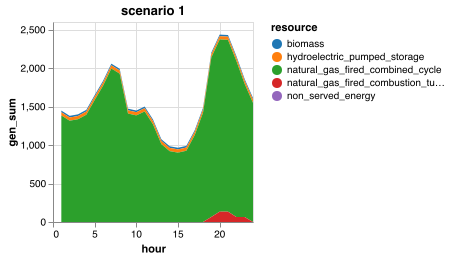

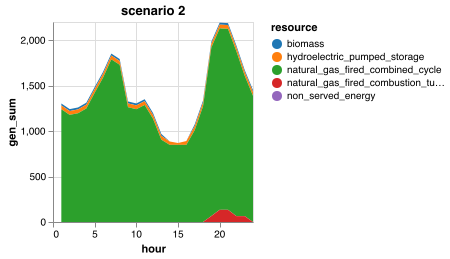

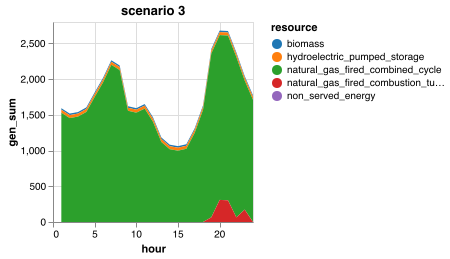

In [9]:
# A spring day
n=100
T_period = (n*24+1):((n+1)*24)

net_load_input = copy(net_load[in.(net_load.hour,Ref(T_period)),:])
net_load_input.hour = net_load_input.hour .- (T_period[1]-1)

load_scenarios = hcat(net_load_input.demand,net_load_input.demand*0.9,net_load_input.demand*1.1)

solution = unit_commitment_stochastic(
    gen_df_no_vre,
    load_scenarios,
    0.01,
    9000
    );

# plot each scenario

for i in 1:3
    gen=solution.gen_all_scenarios[i]
    nse=solution.nse[:,i]
    sol_gen = innerjoin(gen, 
                        gen_df[!, [:r_id, :resource]], 
                        on = :r_id)
    sol_gen = combine(groupby(sol_gen, [:resource, :hour]), 
                :gen => sum)
    
    # add NSE
    nse = DataFrame(resource = repeat(["non_served_energy"]; outer=24), 
        hour = 1:24,
        gen_sum = nse
        )
    append!(sol_gen, nse)
    
    p = sol_gen |>
    @vlplot(:area, 
        x=:hour, y={:gen_sum, stack=:zero}, 
        color={"resource:n", scale={scheme="category10"}},
        title="scenario $i")
    display(p)
end

# Simulator

For our simulation we pick a sequence of 5 days in the summer, where net load increases over time. **When we simulate, we are not going to assume that we actually know the future net load; rather, we will assume that we only know the net load from the previous day, which we use as a "forecast".**

We would normally use many more data points for a simulation, but we choose only 5 so that we can complete this exercise in a lab setting. We will extract 6 days, and use the first day as our first "previous day" to inform our first forecast. We will set the remainder of the net load data aside so that we can use it for policy development if we want.

Let's take a look at the net load timeseries for this 6 day period.

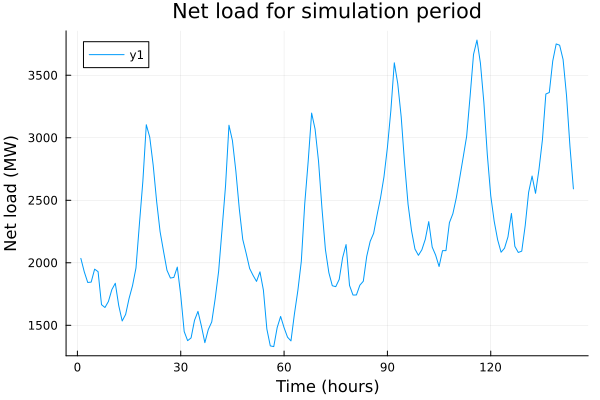

In [114]:
n=186 # we extract the 6 days starting at day 187
T_period = (n*24+1):((n+6)*24)
net_load_for_simulation = copy(net_load[in.(net_load.hour,Ref(T_period)),:])
net_load_for_simulation.hour = net_load_for_simulation.hour .- (T_period[1]-1)
plot(net_load_for_simulation.hour,net_load_for_simulation.demand,xlabel="Time (hours)",ylabel="Net load (MW)",title="Net load for simulation period")

Now we will set aside the rest of the net load timeseries for if we want to use it to develop better policies. We'll refer to it as the "historical" timeseries even though it is really just the whole year of data minus the part we took out. 

In [115]:
historical_net_load = copy(net_load[.!in.(net_load.hour,Ref(T_period)),:]) ;
historical_net_load.hour = 1:length(historical_net_load.hour) ;

Now it's time to initialize our state variable. We introduce both a static state variable, as well as a dynamic state variable that we initialize with the net load for the first day, assuming that we begin our simulation at the end of the first day.

In [116]:
state_variable_static = Dict(
    "gen_df"=>gen_df_no_vre,
    "historical_net_load"=>historical_net_load,
    "nse_cost"=>9000
    ) ;

state_variable_dynamic = Dict(
    "net_load_previous_day" => net_load_for_simulation[1:24,:]
    ) ;

Now we build our simulator. This simulates our decision environment by making a set of unit commitment decisions at the end of each day using the information we have, running economic dispatch on the actual net load, and then updating our contribution function and dynamic state variable based on what happened.

We will first simulate with our stochastic unit commitment policy, which requires a set of scenarios. To start, we will use three scenarios: the previous day's net load, and this net load plus and minus 5%.

Day is 1
Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-27
Set parameter MIPGap to value 0.01
Set parameter MIPGap to value 0.01
Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-27
Set parameter MIPGap to value 0.01
Set parameter MIPGap to value 0.01
Day is 2
Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-27
Set parameter MIPGap to value 0.01
Set parameter MIPGap to value 0.01
Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-27
Set parameter MIPGap to value 0.01
Set parameter MIPGap to value 0.01
Day is 3
Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-27
Set parameter MIPGap to value 0.01
Set parameter MIPGap to value 0.01
Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-27
Set parameter MIPGap to value 0.01
Set parameter MIPGap to value 0.01
Day is 

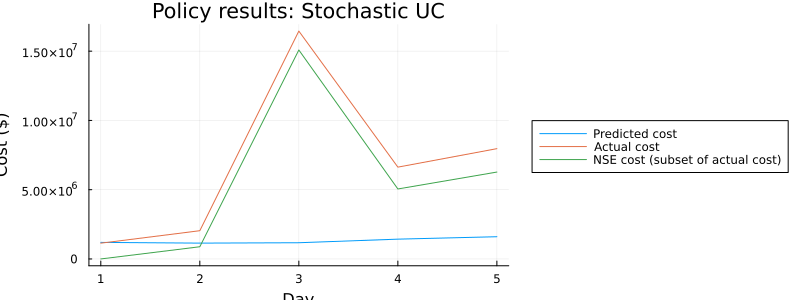

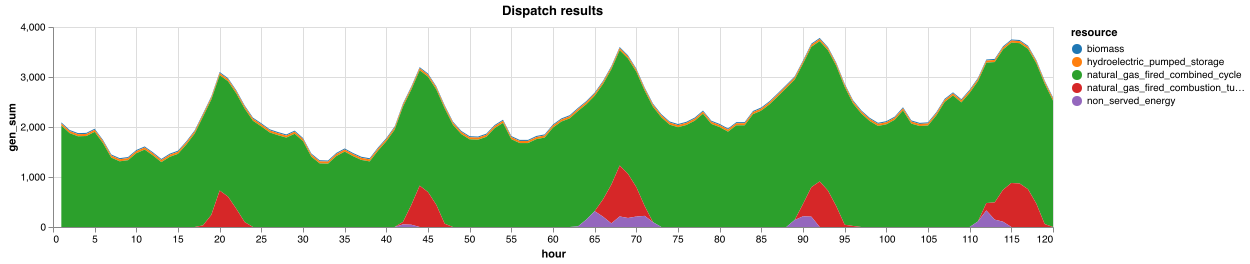

In [129]:
# A simulator!

# initialize outputs
contribution_total = 0.0
policy_results = DataFrame(day=Int[], predicted_cost = Float64[], actual_cost_total = Float64[], actual_cost_nse = Float64[])
dispatch_results=DataFrame(resource=String[],hour=Int64[],gen_sum=Float64[])

# re-define dynamic state variable in case we run this multiple times
state_variable_dynamic = Dict(
    "net_load_previous_day" => net_load_for_simulation[1:24,:]
    ) ;

for day in 1:5

    println("Day is $day")

    net_load_previous_day = state_variable_dynamic["net_load_previous_day"]
    
    load_scenarios_for_stochastic_UC = hcat(net_load_previous_day.demand,net_load_previous_day.demand*0.95,net_load_previous_day.demand*1.05)

    stochastic_UC_solution = unit_commitment_stochastic(
        state_variable_static["gen_df"],
        load_scenarios_for_stochastic_UC,
        0.01,
        state_variable_static["nse_cost"]
        );    

    # decision variable = set of commitment decisions
    x_G_t = stochastic_UC_solution.commit

    # we also record the start cost, which we know in advance because our commitment schedule is now known.
    start_cost = stochastic_UC_solution.start_cost

    #### ...... 24 hours later ...... ####

    # Initialize dict for exogenous information. This will consist of both the actual net load, and the dispatch results.
    W_tplus1 = Dict()

    # Let's get the net load that actually occurred. This is part of our exogenous information.
    time_current_day = (day*24+1):((day+1)*24)
    net_load_actual = copy(net_load_for_simulation[in.(net_load_for_simulation.hour,Ref(time_current_day)),:])
    net_load_actual.hour = 1:24
    W_tplus1["net_load_actual"] = net_load_actual

    # Now we run economic dispatch on this actual net load to see how our commitment decisions performed. We add the actual energy and NSE cost to our exogenous information.

    economic_dispatch_solution = economic_dispatch(
        state_variable_static["gen_df"],
        net_load_actual,
        0.01,
        x_G_t,
        state_variable_static["nse_cost"]
        );

    W_tplus1["energy_cost_actual"] = economic_dispatch_solution.energy_cost
    W_tplus1["nse_cost_actual"] = economic_dispatch_solution.nse_cost

    # We also record the dispatch so we can see what happened.
    sol_gen = combine(groupby(innerjoin(economic_dispatch_solution.gen, state_variable_static["gen_df"][!, [:r_id, :resource]], on = :r_id),[:resource, :hour]), :gen => sum)
    append!(sol_gen, DataFrame(resource = repeat(["non_served_energy"]; outer=24), hour = 1:24,gen_sum = economic_dispatch_solution.nse))
    sol_gen.hour .= sol_gen.hour .+ 24*(day-1)
    dispatch_results=vcat(dispatch_results,sol_gen)

    # Now we run our transition function, which in this case is very simple: updating the previous day's net load for our next decision.
    state_variable_dynamic["net_load_previous_day"] = net_load_actual

    # Finally we record our "contributions", which are the start costs (which we knew in advance), the actual energy costs, and the actual nse costs.
    contribution_total += start_cost + W_tplus1["energy_cost_actual"] + W_tplus1["nse_cost_actual"]

    # We also record our relevant results to our policy results dataframe
    new_row = (
        day=day,
        predicted_cost=stochastic_UC_solution.cost,
        actual_cost_total=start_cost + W_tplus1["energy_cost_actual"] + W_tplus1["nse_cost_actual"],
        actual_cost_nse=W_tplus1["nse_cost_actual"]
        )
        
    push!(policy_results,new_row)

end

# Now we plot the results of our policy
p1=plot(policy_results.day,policy_results.predicted_cost,label="Predicted cost",xlabel="Day",ylabel="Cost (\$)",title="Policy results: Stochastic UC",legend = :outerright,size = (800, 300))
plot!(p1,policy_results.day,policy_results.actual_cost_total,label="Actual cost")
plot!(p1,policy_results.day,policy_results.actual_cost_nse,label="NSE cost (subset of actual cost)")
display(p1)

plot2=dispatch_results |>
@vlplot(:area, 
    x=:hour, y={:gen_sum, stack=:zero}, 
    color={"resource:n", scale={scheme="category10"}},width=1000,title="Dispatch results")
display(plot2)

You can see that there is non-served energy on the last three days! This is because the scenarios were not sufficient to cover the net load pattern that actually happened. Can you find a better policy that minimizes start costs while also not resulting in any non-served energy?

Now it's your turn. In the rest of this notebook, please complete the following tasks:

- Write down what you think will happen when you use each of the three policies for this (for stochastic you already know the answer). Then, test them each, and write down the result. Keep in mind that the input format for loads is slightly different for the deterministic versions.
- Try to improve both the reserves policy, and the stochastic policy. Then, compare the results plot for both of them. Is one of them a better policy?